# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


from google.colab import drive
drive.mount('/content/gdrive')

!ls /content/gdrive/My\ Drive/PROJ/*.py

import sys
sys.path.append('/content/gdrive/My Drive/PROJ/')
from get_dataset_mine import fetch_dataset

# Vanilla Autoencoder (3 балла)

---



## Prepare the data


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# fix randoms

rnd = 383

import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES']='-1'
os.environ['TF_CUDNN_USE_AUTOTUNE'] ='0'
from numpy.random import seed
import random
seed(rnd)
random.seed(rnd)
np.random.seed(rnd)

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset_mine import fetch_dataset
data, attrs = fetch_dataset()

In [4]:
# Hyperparameters

IMAGE_H  = data.shape[1]
IMAGE_W  = data.shape[2]
channels = data.shape[3]
epoch    = 250
batch    = 250
hid_size = 512
dimZ     = 64
lr       = 1e-4

**Знакомство с данными**

In [5]:
data.shape, data[0].dtype, np.prod(data[0].shape)

((13143, 45, 45, 3), dtype('uint8'), 6075)

In [6]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,...,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,...,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,...,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,...,-1.46147,-0.955283,0.119113,-1.12818,-3.16105,0.0826804,-0.439614,-0.359859,-0.760774,-0.410152


In [7]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa


Разбейте выборку картинок на train и val и приведите значения элементов в интервал [0, 1] типа float

In [8]:
idx_train = random.sample(range(13143), 10000)
idx_test  = set(range(13143)) - set(idx_train)
len(idx_test)

3143

In [9]:
x_train = np.array([data[i] for i in idx_train]).astype('float32')/255
x_test = np.array([data[i] for i in idx_test]).astype('float32')/255

In [10]:
attrs.Smiling.max(), attrs.Smiling.min(), attrs.Male.max(), attrs.Male.min()

(2.83999377045, -2.68659390331, 3.7508873897300004, -3.6728711234300007)

In [11]:
attrs_train = attrs.loc[idx_train].reset_index(drop=True)
attrs_test = attrs.loc[idx_test].reset_index(drop=True)
attrs_test.shape

(3143, 73)

In [12]:
p1, p2, p3, p4, p5, p6, p7, p8 = 1., 1.95, 1.814, 2., 1.498, 2., 1., 1.
print(attrs_test[(attrs_test['Smiling'] > p1) & (attrs_test['Male'] > p2)].shape,
      attrs_test[(attrs_test['Smiling'] > p3) & (attrs_test['Male'] < -p4)].shape)
print(attrs_test[(attrs_test['Smiling'] < -p5) & (attrs_test['Male'] > p6)].shape,
      attrs_test[(attrs_test['Smiling'] < -p7) & (attrs_test['Male'] < -p8)].shape)

(25, 73) (25, 73)
(25, 73) (25, 73)


In [13]:
up_idxs = np.sort(np.concatenate([attrs_test[(attrs_test['Smiling'] > p1) & (attrs_test['Male'] > p2)].index,
                                  attrs_test[(attrs_test['Smiling'] > p3) & (attrs_test['Male'] < -p4)].index]))
dn_idxs = np.sort(np.concatenate([attrs_test[(attrs_test['Smiling'] < -p5) & (attrs_test['Male'] > p6)].index,
                                  attrs_test[(attrs_test['Smiling'] < -p7) & (attrs_test['Male'] < -p8)].index]))
up_idxs.shape, dn_idxs.shape

((50,), (50,))

In [14]:
up_sense = np.array([x_test[i] for i in up_idxs])
dn_sense = np.array([x_test[i] for i in dn_idxs])
len(up_sense), len(dn_sense), up_sense[0][0][0]

(50, 50, array([0.26666668, 0.09803922, 0.00392157], dtype=float32))

In [15]:
data[0].shape, up_sense[0].shape

((45, 45, 3), (45, 45, 3))

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [16]:
def plot_gallery(images, h, w, n_row=4, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

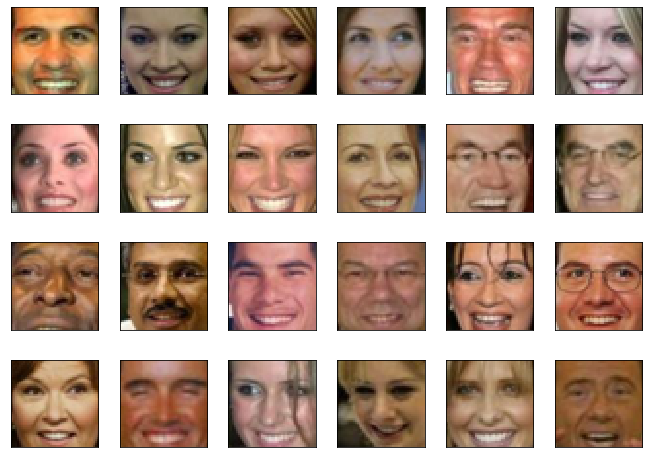

In [17]:
plot_gallery(up_sense, IMAGE_H, IMAGE_W)

In [18]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами.

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [19]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Input, Dense, Flatten, Reshape
from keras.layers import Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras import optimizers

Using TensorFlow backend.


In [20]:
def create_deep_dense_ae():

    def apply_bn_and_dropout(x):
        return Dropout(.2)(BatchNormalization()(x))
    
    # Энкодер
    input_img = Input(shape=(IMAGE_H, IMAGE_W, channels))
    flat_img = Flatten()(input_img)
    x = Dense(hid_size, activation='elu')(flat_img)
    x = apply_bn_and_dropout(x)
    encoded = Dense(dimZ, activation='linear')(x)
    
    # Декодер
    input_encoded = Input(shape=(dimZ,))
    x = Dense(hid_size, activation='elu')(input_encoded)
    x = apply_bn_and_dropout(x)
    flat_decoded = Dense(IMAGE_H * IMAGE_W * channels, activation='sigmoid')(x)
    decoded = Reshape((IMAGE_H, IMAGE_W, 3))(flat_decoded)
    
    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

d_encoder, d_decoder, d_autoencoder = create_deep_dense_ae()
d_autoencoder.compile(optimizer=optimizers.Adam(lr),
                      loss='mean_squared_error',     # 'binary_crossentropy'
                      metrics=['accuracy'])

In [21]:
# Посмотрим на число параметров

print(d_encoder.summary())
print(d_decoder.summary())
print(d_autoencoder.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 45, 45, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6075)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               3110912   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
Total params: 3,145,792
Trainable params: 3,144,768
Non-trainable params: 1,024
_____________________________________________

In [22]:
x_train.shape, x_test.shape

((10000, 45, 45, 3), (3143, 45, 45, 3))

In [23]:
# Обучим теперь наш автоэнкодер

history = d_autoencoder.fit(x_train, x_train,
                            epochs=epoch,
                            batch_size=batch,
                            shuffle=True,
                            validation_data=(x_test, x_test),
                            verbose=2,
                            callbacks = [EarlyStopping(patience = 5)])

Train on 10000 samples, validate on 3143 samples
Epoch 1/250
 - 15s - loss: 0.0429 - accuracy: 0.3429 - val_loss: 0.0848 - val_accuracy: 0.3341
Epoch 2/250
 - 13s - loss: 0.0337 - accuracy: 0.3767 - val_loss: 0.0620 - val_accuracy: 0.4576
Epoch 3/250
 - 15s - loss: 0.0310 - accuracy: 0.4187 - val_loss: 0.0403 - val_accuracy: 0.7358
Epoch 4/250
 - 14s - loss: 0.0291 - accuracy: 0.4458 - val_loss: 0.0265 - val_accuracy: 0.7982
Epoch 5/250
 - 14s - loss: 0.0273 - accuracy: 0.4696 - val_loss: 0.0194 - val_accuracy: 0.8075
Epoch 6/250
 - 15s - loss: 0.0255 - accuracy: 0.5000 - val_loss: 0.0193 - val_accuracy: 0.8170
Epoch 7/250
 - 14s - loss: 0.0238 - accuracy: 0.5372 - val_loss: 0.0177 - val_accuracy: 0.8273
Epoch 8/250
 - 15s - loss: 0.0218 - accuracy: 0.5848 - val_loss: 0.0171 - val_accuracy: 0.7900
Epoch 9/250
 - 15s - loss: 0.0197 - accuracy: 0.6383 - val_loss: 0.0131 - val_accuracy: 0.8928
Epoch 10/250
 - 15s - loss: 0.0175 - accuracy: 0.6990 - val_loss: 0.0123 - val_accuracy: 0.8813


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


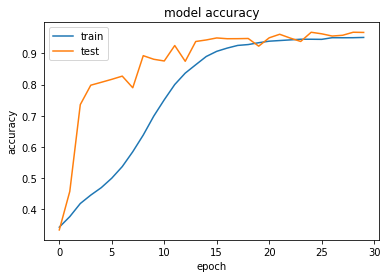

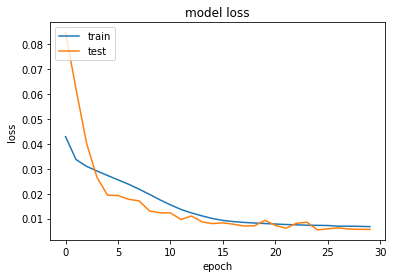

In [24]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
# Функция отрисовки изображений

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

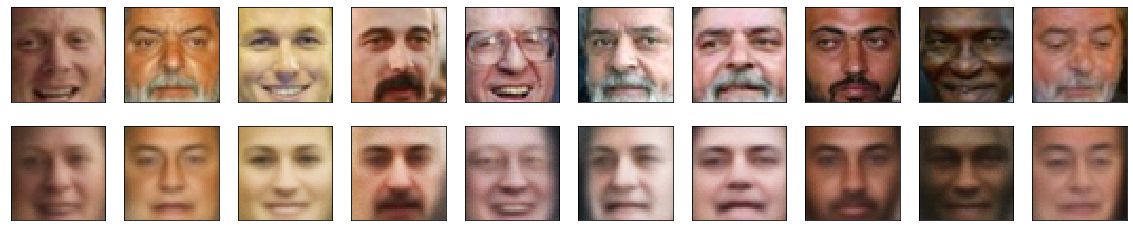

In [26]:
n = 10

imgs = x_test[:n]
encoded_imgs = d_encoder.predict(imgs, batch_size=n)
encoded_imgs[0]

decoded_imgs = d_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

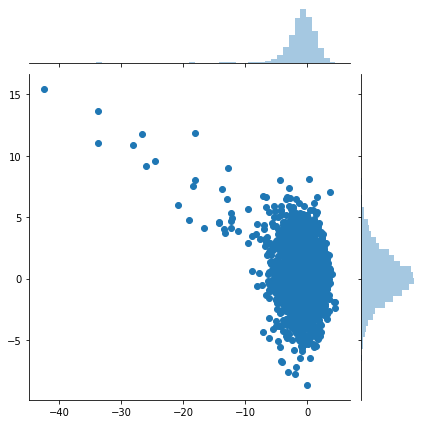

In [27]:
import seaborn as sns

codes = d_encoder.predict(x_test)
sns.jointplot(codes[:,1], codes[:,3])

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что придется рандом подогнать.

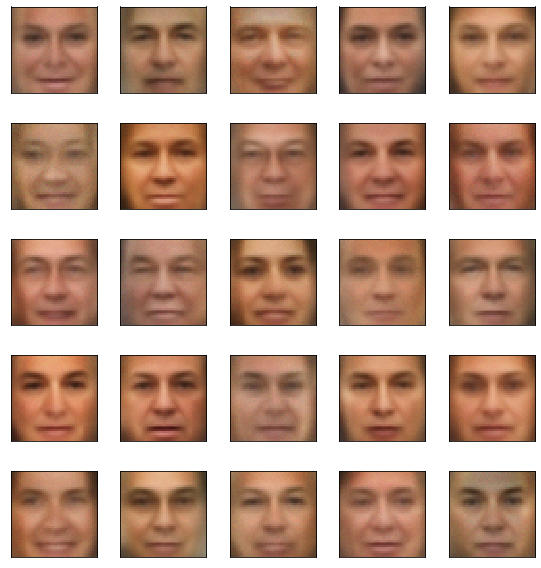

In [28]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dimZ)           # 100 - <latent_space_dim>
output = d_decoder.predict(z)           # <скормите z декодеру>
plot_gallery(output, IMAGE_H, IMAGE_W, n_row=5, n_col=5)    # output.data.cpu().numpy()

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [29]:
# получим вектора латентного слоя улыбчивой и расстроенной выборок
# latents_up_mean - latents_dn_mean -- вектором улыбки
# -latents_up_mean + latents_dn_mean -- вектор печали

latents_up_mean = d_encoder.predict(up_sense).mean(axis=0)
latents_dn_mean = d_encoder.predict(dn_sense).mean(axis=0)
latents_up_mean.shape

(64,)

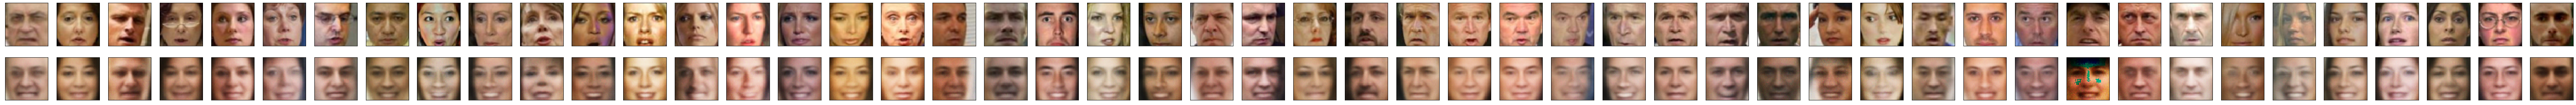

In [30]:
# обрадуем печальных

encoded_imgs = d_encoder.predict(dn_sense)-latents_dn_mean+latents_up_mean
decoded_imgs = d_decoder.predict(encoded_imgs)

plot_digits(dn_sense, decoded_imgs)

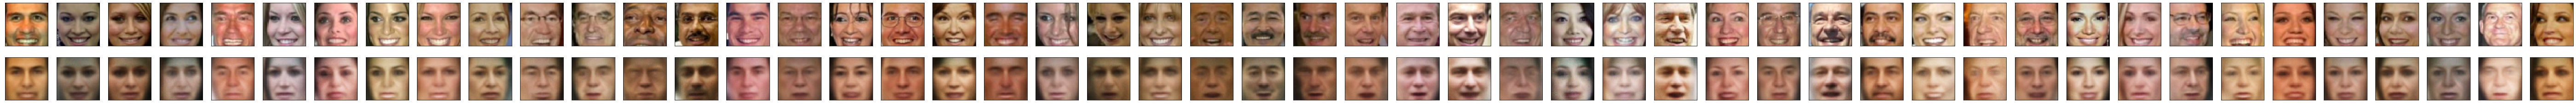

In [31]:
# расстроим весёлых

encoded_imgs = d_encoder.predict(up_sense)+(latents_dn_mean-latents_up_mean)
decoded_imgs = d_decoder.predict(encoded_imgs)

plot_digits(up_sense, decoded_imgs)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии)